In [1]:
INPUT = "model_data/example_study"

In [2]:
# Standard library imports
import os
import math
import glob
import json
import pickle

# Third-party library imports
import torch
import torchvision
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
import pydicom
import sklearn
import sklearn.metrics


# Local module imports
import utils
import video_utils

## Load Weights

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
checkpoint = torch.load("model_data/weights/echo_prime_encoder.pt",map_location=device)
echo_encoder = torchvision.models.video.mvit_v2_s()
echo_encoder.head[-1] = torch.nn.Linear(echo_encoder.head[-1].in_features, 512)
echo_encoder.load_state_dict(checkpoint)
echo_encoder.eval()
echo_encoder.to(device)
for param in echo_encoder.parameters():
    param.requires_grad = False
    
vc_checkpoint = torch.load("model_data/weights/view_classifier.ckpt",map_location=device)
vc_state_dict={key[6:]:value for key,value in vc_checkpoint['state_dict'].items()}
view_classifier = torchvision.models.convnext_base()
view_classifier.classifier[-1] = torch.nn.Linear(
    view_classifier.classifier[-1].in_features, 11
)
view_classifier.load_state_dict(vc_state_dict)
view_classifier.to(device)
view_classifier.eval()
for param in view_classifier.parameters():
    param.requires_grad = False

## Preprocess Data

In [ ]:
frames_to_take=32
frame_stride=2
video_size=224
mean = torch.tensor([29.110628, 28.076836, 29.096405]).reshape(3, 1, 1, 1)
std = torch.tensor([47.989223, 46.456997, 47.20083]).reshape(3, 1, 1, 1)

def process_dicoms(INPUT):
    """
    Reads DICOM video data from the specified folder and returns a tensor 
    formatted for input into the EchoPrime model.

    Args:
        INPUT (str): Path to the folder containing DICOM files.

    Returns:
        stack_of_videos (torch.Tensor): A float tensor of shape  (N, 3, 16, 224, 224)
                                        representing the video data where N is the number of videos,
                                        ready to be fed into EchoPrime.
    """

    dicom_paths = glob.glob(f'{INPUT}/**/*',recursive=True)
    stack_of_videos=[]
    for idx, dicom_path in tqdm(enumerate(dicom_paths),total=len(dicom_paths)):
        try:
            # simple dicom_processing
            dcm=pydicom.dcmread(dicom_path)
            pixels = dcm.pixel_array
            
            # exclude images like (600,800) or (600,800,3)
            if pixels.ndim < 3 or pixels.shape[2]==3:
                continue 
                
            # if single channel repeat to 3 channels    
            if pixels.ndim==3:
                
                pixels = np.repeat(pixels[..., None], 3, axis=3)
            
            # mask everything outside ultrasound region
            pixels=video_utils.mask_outside_ultrasound(dcm.pixel_array)
            
            
            
            #model specific preprocessing
            x = np.zeros((len(pixels),224,224,3))
            for i in range(len(x)):
                x[i] = video_utils.crop_and_scale(pixels[i])
            
            x = torch.as_tensor(x, dtype=torch.float).permute([3,0,1,2])
            # normalize
            x.sub_(mean).div_(std)
        
            ## if not enough frames add padding
            if x.shape[1] < frames_to_take:
                padding = torch.zeros(
                (
                    3,
                    frames_to_take - x.shape[1],
                    video_size,
                    video_size,
                ),
                dtype=torch.float,
                )
                x = torch.cat((x, padding), dim=1)
                
            start=0
            stack_of_videos.append(x[:, start : ( start + frames_to_take) : frame_stride, : , : ])
            
        except Exception as e:
            print("corrupt file")
            print(str(e))

    stack_of_videos=torch.stack(stack_of_videos)
    
    return stack_of_videos

In [6]:
def embed_videos(stack_of_videos):
    """
    Given a set of videos that belong to one echocardiogram study,
    embed them in the latent space using EchoPrime encoder
    
    Args:
        stack_of_videos (torch.Tensor): A float tensor of shape (N, 3, 16, 224, 224)
                                        with preprocessed echo video data
        
    Returns:
        stack_of_features (torch.Tensor) A float tensor of shape (N, 512)
                                         with latent embeddings corresponding to echo videos
    """
    bin_size=50
    n_bins=math.ceil(stack_of_videos.shape[0]/bin_size)
    stack_of_features_list=[]
    with torch.no_grad():
        for bin_idx in range(n_bins):
            start_idx = bin_idx * bin_size
            end_idx = min( (bin_idx + 1) * bin_size, stack_of_videos.shape[0])
            bin_videos = stack_of_videos[start_idx:end_idx].to(device)
            bin_features = echo_encoder(bin_videos)
            stack_of_features_list.append(bin_features)
        stack_of_features=torch.cat(stack_of_features_list,dim=0)
    return stack_of_features

In [7]:
def get_views(stack_of_videos, visualize=False):
    """
    Args:
        stack_of_videos (torch.Tensor): A float tensor with preprocessed echo video data
        
    Returns:
        stack_of_view_encodings (torch.Tensor) A float tensor of one hot embeddings with shape (N, 11)
                                               representing echocardiogram views
    """
    ## get views   
    stack_of_first_frames = stack_of_videos[:,:,0,:,:].to(device)
    with torch.no_grad():
        out_logits=view_classifier(stack_of_first_frames)
    out_views=torch.argmax(out_logits,dim=1)
    view_list = [utils.COARSE_VIEWS[v] for v in out_views]
    stack_of_view_encodings = torch.stack([torch.nn.functional.one_hot(out_views,11)]).squeeze().to(device)

    # visualize images and the assigned views
    if visualize:
        print("Preprocessed and normalized video inputs")
        rows, cols = (len(view_list) // 12 + (len(view_list) % 9 > 0)), 12
        fig, axes = plt.subplots(rows, cols, figsize=(cols, rows))
        axes = axes.flatten()
        for i in range(len(view_list)):
            display_image = (stack_of_first_frames[i].cpu().permute([1,2,0]) * 255).numpy()
            display_image = np.clip(display_image, 0, 255).astype('uint8')
            display_image = np.ascontiguousarray(display_image)
            display_image = cv2.cvtColor(display_image, cv2.COLOR_RGB2BGR)
            cv2.putText(display_image, view_list[i].replace("_"," "), (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 220, 255), 2)
            axes[i].imshow(display_image)
            axes[i].axis('off')

        for j in range(i + 1, len(axes)):
            axes[j].axis('off')
        plt.subplots_adjust(wspace=0.05, hspace=0.05)
        plt.show()

        
    return stack_of_view_encodings

In [8]:
def encode_study(INPUT,visualize=False):
    """
    Produces an EchoPrime embedding of the echocardiography study

    Args:
        INPUT (str): Path to the folder containing DICOM files.
        
    Returns:
        encoded_study (torch.Tensor): A float tensor of shape (N, 523)
    """
    stack_of_videos=process_dicoms(INPUT)
    stack_of_features=embed_videos(stack_of_videos)
    stack_of_view_encodings=get_views(stack_of_videos,visualize)
    encoded_study = torch.cat( (stack_of_features ,stack_of_view_encodings),dim=1)
    
    return encoded_study

100%|████████████████████████████████████████████████████████████████████████| 50/50 [00:14<00:00,  3.51it/s]


Preprocessed and normalized video inputs


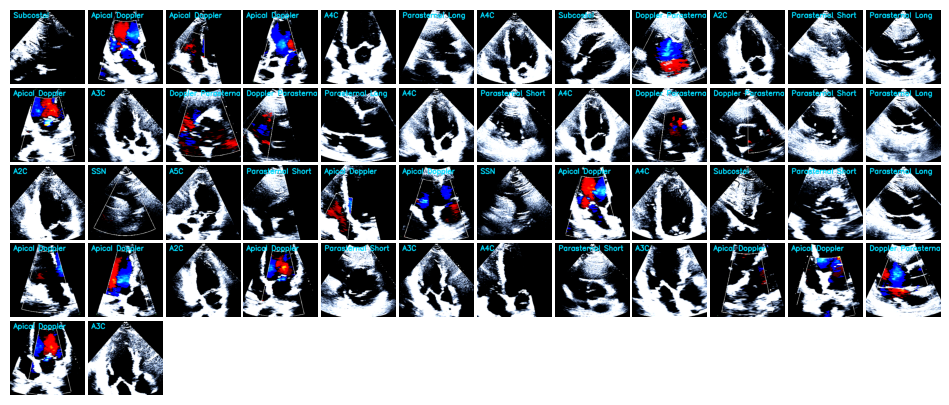

In [9]:
encoded_study=encode_study(INPUT, visualize=True)

# Obtain Interpretations

In [ ]:
# load MIL weights per section
MIL_weights = pd.read_csv("../weights/MIL_weights.csv")
non_empty_sections=MIL_weights['Section']
section_weights=MIL_weights.iloc[:,1:].to_numpy()

In [11]:
# Load candidate reports
candidate_studies=list(pd.read_csv("model_data/candidates_data/candidate_studies.csv")['Study'])
candidate_embeddings_p1=torch.load("model_data/candidates_data/candidate_embeddings_p1.pt")
candidate_embeddings_p2=torch.load("model_data/candidates_data/candidate_embeddings_p2.pt")
candidate_embeddings=torch.cat((candidate_embeddings_p1,candidate_embeddings_p2),dim=0)
# Optionally normalize each candidate embedding vector
# candidate_embeddings = torch.nn.functional.normalize(candidate_embeddings,dim=1)
candidate_reports=pd.read_pickle("model_data/candidates_data/candidate_reports.pkl")
candidate_reports = [utils.phrase_decode(vec_phr) for vec_phr in tqdm(candidate_reports)]
candidate_labels = pd.read_pickle("model_data/candidates_data/candidate_labels.pkl")
section_to_phenotypes = pd.read_pickle("section_to_phenotypes.pkl")

100%|███████████████████████████████████████████████████████████| 1230676/1230676 [00:15<00:00, 79649.22it/s]


In [12]:
def generate_report(study_embedding: torch.Tensor) -> str:
    """
    Given the EchoPrime study embedding generate a report
    for each section focus on the views weighted
    Args:
        study_embedding - torch tensor of shape num_videos x 572
        original_report - text for original study
    """
    study_embedding=study_embedding.cpu()
    generated_report=""
    for s_dx, sec in enumerate(non_empty_sections):
        # need to multiply it based on what section does the view belong to.
        cur_weights=[section_weights[s_dx][torch.where(ten==1)[0]] for ten in study_embedding[:,512:]]
        no_view_study_embedding = study_embedding[:,:512] * torch.tensor(cur_weights,dtype=torch.float).unsqueeze(1)
        # weights by views.
        no_view_study_embedding=torch.mean(no_view_study_embedding,dim=0)
        no_view_study_embedding=torch.nn.functional.normalize(no_view_study_embedding,dim=0)
        similarities=no_view_study_embedding @ candidate_embeddings.T
        
        extracted_section="Section not found."
        while extracted_section=="Section not found.":
            max_id = torch.argmax(similarities)
            predicted_section = candidate_reports[max_id]
            extracted_section = utils.extract_section(predicted_section,sec)
            if extracted_section != "Section not found.":
                generated_report+= extracted_section
            similarities[max_id]=float('-inf')
            
    return generated_report

In [13]:
def predict_metrics(study_embedding: torch.Tensor,
                   k=50) -> dict:
    """
    study_embedding is a set of embeddings of all videos from the study e.g (52,512)
    Takes a study embedding as input and
    outputs a dictionary for a set of 26 features
    """
    #per_section_study_embedding has shape (15,512)
    per_section_study_embedding=torch.zeros(len(non_empty_sections),512)
    study_embedding=study_embedding.cpu()
    # make per section study embedding
    for s_dx, sec in enumerate(non_empty_sections):
        # get section weights
        this_section_weights=[section_weights[s_dx][torch.where(view_encoding==1)[0]]
                      for view_encoding in study_embedding[:,512:]]
        this_section_study_embedding = (study_embedding[:,:512] * \
                                        torch.tensor(this_section_weights,
                                                     dtype=torch.float).unsqueeze(1))
        
        #weighted average
        this_section_study_embedding=torch.sum(this_section_study_embedding,dim=0)
        per_section_study_embedding[s_dx]=this_section_study_embedding
        
    per_section_study_embedding=torch.nn.functional.normalize(per_section_study_embedding)
    #similarities has shape (15,230676)
    similarities=per_section_study_embedding @ candidate_embeddings.T

    # for each row find indices of 50 highest values
    #top_candidate_ids has shape (15,50)
    top_candidate_ids=torch.topk(similarities, k=k, dim=1).indices
    #now predict for each phenotype:
    preds={}
    for s_dx, section in enumerate(section_to_phenotypes.keys()):
        for pheno in section_to_phenotypes[section]:
            preds[pheno] = np.nanmean([candidate_labels[pheno][candidate_studies[c_ids]]
                                   for c_ids in top_candidate_ids[s_dx]
                                      if candidate_studies[c_ids] in candidate_labels[pheno]])
    
    return preds

In [14]:
generate_report(encoded_study)

'Left Ventricle: Normal left ventricular size by linear cavity dimension. Normal left ventricular size by volume Mild left ventricular hypertrophy. Normal left ventricular systolic function. LV Ejection Fraction is 60.0 %. Mild diastolic dysfunction. There is reversal of the E to A ratio and/or prolonged deceleration time consistent with impaired left ventricular relaxation. Doppler parameters and/or lateral mitral annular (E`) velocities are consistent with normal left ventricular filling pressures. [SEP]Resting Segmental Wall Motion Analysis: Total wall motion score is 1.0. There are no regional wall motion abnormalities [SEP]Right Ventricle: Normal right ventricular size. Normal right ventricular systolic function. [SEP]Left Atrium: The left atrium is normal in size. [SEP]Right Atrium: The right atrium is normal in size. [SEP]Atrial Septum: The interatrial septum is normal in appearance. [SEP]Mitral Valve: The mitral valve demonstrates normal function with trace physiologic regurgit

In [15]:
print("Feature logits")
predict_metrics(encoded_study)

Feature logits


{'impella': 0.0,
 'ejection_fraction': 56.28,
 'pacemaker': 0.02,
 'rv_systolic_function_depressed': 0.0,
 'right_ventricle_dilation': 0.0,
 'left_atrium_dilation': 0.0,
 'right_atrium_dilation': 0.0,
 'mitraclip': 0.0,
 'mitral_annular_calcification': 0.0,
 'mitral_stenosis': 0.0,
 'mitral_regurgitation': 0.0,
 'tavr': 0.0,
 'bicuspid_aov_morphology': 0.0,
 'aortic_stenosis': 0.0,
 'aortic_regurgitation': 0.0,
 'tricuspid_stenosis': 0.0,
 'tricuspid_valve_regurgitation': 0.0,
 'pericardial_effusion': 0.0,
 'aortic_root_dilation': 0.0,
 'dilated_ivc': 0.02,
 'pulmonary_artery_pressure_continuous': 22.08823529411765}

It's good to pick ROC thresholds based on a val set from your institution. 

We provide ROC thresholds that maximize true positive rate and minize false positive rate on val studies from Cedars Sinai Medical Center in roc_thresholds.csv file